In [1]:
import zipfile
zip_ref = zipfile.ZipFile('fictional-character-battle-outcome-prediction.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

In [2]:
! pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.stats import shapiro, ttest_ind, f_oneway

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
df = pd.read_csv("fictional_character_battles_complex.csv")

In [4]:
df.head()

,Character,Universe,Strength,Speed,Intelligence,SpecialAbilities,Weaknesses,BattleOutcome
0,Wonder Woman,Marvel,7,8,3,Telekinesis,Kryptonite,0
1,Iron Man,Marvel,4,7,9,Telekinesis,Kryptonite,0
2,Iron Man,DC Comics,8,7,5,Telekinesis,Magic,0
3,Spider-Man,DC Comics,5,6,10,Telekinesis,Kryptonite,0
4,Flash,Marvel,7,6,2,Invisibility,Magic,0


In [5]:
df.isnull().sum()

Character           0
Universe            0
Strength            0
Speed               0
Intelligence        0
SpecialAbilities    0
Weaknesses          0
BattleOutcome       0
dtype: int64

In [6]:
# Check for duplicates and remove them
duplicates = df.duplicated()
print("\nNumber of Duplicates:", duplicates.sum())


Number of Duplicates: 6


In [7]:
df = df.drop_duplicates()

In [8]:
# Basic info and statistics
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2345 entries, 0 to 2350
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Character         2345 non-null   object
 1   Universe          2345 non-null   object
 2   Strength          2345 non-null   int64 
 3   Speed             2345 non-null   int64 
 4   Intelligence      2345 non-null   int64 
 5   SpecialAbilities  2345 non-null   object
 6   Weaknesses        2345 non-null   object
 7   BattleOutcome     2345 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 164.9+ KB


In [9]:
print("\nData Description:\n", df.describe())


Data Description:
           Strength        Speed  Intelligence  BattleOutcome
count  2345.000000  2345.000000   2345.000000    2345.000000
mean      5.441365     5.481450      5.550107       0.278038
std       2.896110     2.858841      2.861892       0.448128
min       1.000000     1.000000      1.000000       0.000000
25%       3.000000     3.000000      3.000000       0.000000
50%       5.000000     6.000000      6.000000       0.000000
75%       8.000000     8.000000      8.000000       1.000000
max      10.000000    10.000000     10.000000       1.000000


In [10]:
# Calculate IQR
Q1 = df[['Strength', 'Speed', 'Intelligence']].quantile(0.25)
Q3 = df[['Strength', 'Speed', 'Intelligence']].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
df = df[~((df[['Strength', 'Speed', 'Intelligence']] < (Q1 - 1.5 * IQR)) | (df[['Strength', 'Speed', 'Intelligence']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [11]:
# Normalize data using Quantile Transformer and check with Shapiro-Wilk test
for column in ['Strength', 'Speed', 'Intelligence']:
    qt = QuantileTransformer()
    df[[column]] = qt.fit_transform(df[[column]])
    
    # Check normalization with Shapiro-Wilk test
    stat, p = shapiro(df[column])
    print(f'\nShapiro-Wilk Test for {column}: Statistics=%.3f, p=%.3f' % (stat, p))

    if p < 0.05:
        # Apply Power Transformer if not normally distributed
        pt = PowerTransformer()
        df[[column]] = pt.fit_transform(df[[column]])


Shapiro-Wilk Test for Strength: Statistics=0.947, p=0.000

Shapiro-Wilk Test for Speed: Statistics=0.948, p=0.000

Shapiro-Wilk Test for Intelligence: Statistics=0.948, p=0.000


In [12]:
# t-test between two groups (example)
t_stat, t_p = ttest_ind(df[df['Universe'] == 'Marvel']['Strength'], df[df['Universe'] == 'DC Comics']['Strength'])
print('\nT-test: t=%.3f, p=%.3f' % (t_stat, t_p))


T-test: t=1.512, p=0.131


In [13]:
print("\n--- T-tests ---")
t_test_results = []
for col1 in ['Strength', 'Speed', 'Intelligence']:
    for col2 in ['Strength', 'Speed', 'Intelligence']:
        if col1 != col2:
            t_stat, t_p = ttest_ind(df[col1], df[col2])
            t_test_results.append({
                'Comparison': f'{col1} vs {col2}',
                'T Statistic': t_stat,
                'p-value': t_p
            })
            print(f'T-test between {col1} and {col2}: t-statistic={t_stat:.3f}, p-value={t_p:.3f}')


--- T-tests ---
T-test between Strength and Speed: t-statistic=0.000, p-value=1.000
T-test between Strength and Intelligence: t-statistic=-0.000, p-value=1.000
T-test between Speed and Strength: t-statistic=0.000, p-value=1.000
T-test between Speed and Intelligence: t-statistic=-0.000, p-value=1.000
T-test between Intelligence and Strength: t-statistic=0.000, p-value=1.000
T-test between Intelligence and Speed: t-statistic=0.000, p-value=1.000


In [14]:
print("\n--- ANOVA ---")
anova_results = {}
anova_stat, anova_p = f_oneway(df['Strength'], df['Speed'], df['Intelligence'])
anova_results['ANOVA'] = {
    'F-statistic': anova_stat,
    'p-value': anova_p
}
print(f'ANOVA: F-statistic={anova_stat:.3f}, p-value={anova_p:.3f}')


--- ANOVA ---
ANOVA: F-statistic=0.000, p-value=1.000


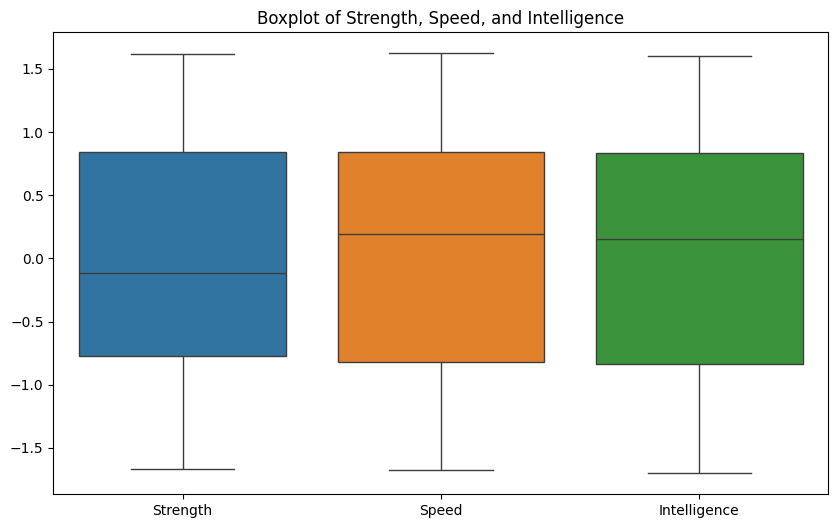

In [15]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Strength', 'Speed', 'Intelligence']])
plt.title("Boxplot of Strength, Speed, and Intelligence")
plt.show()

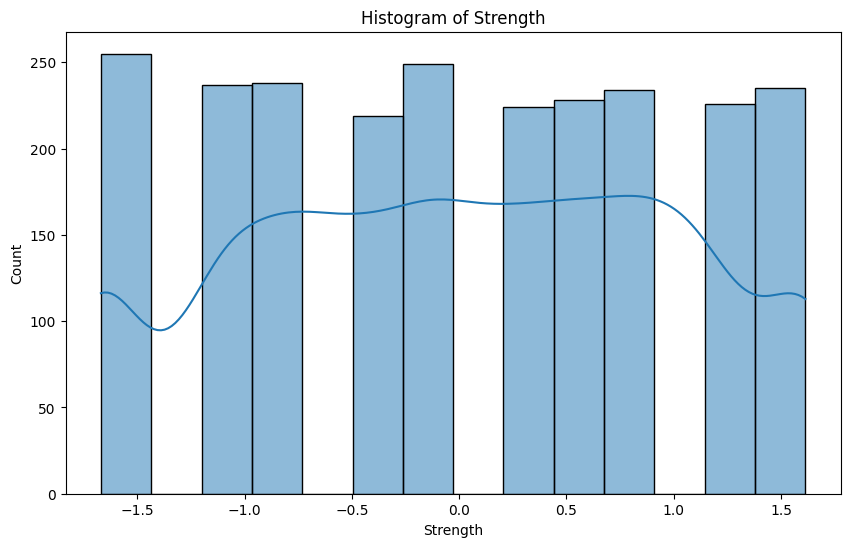

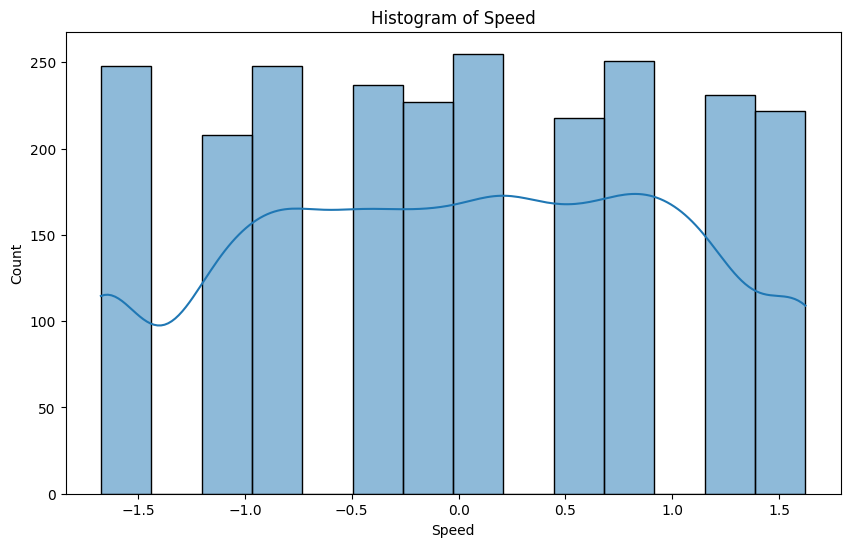

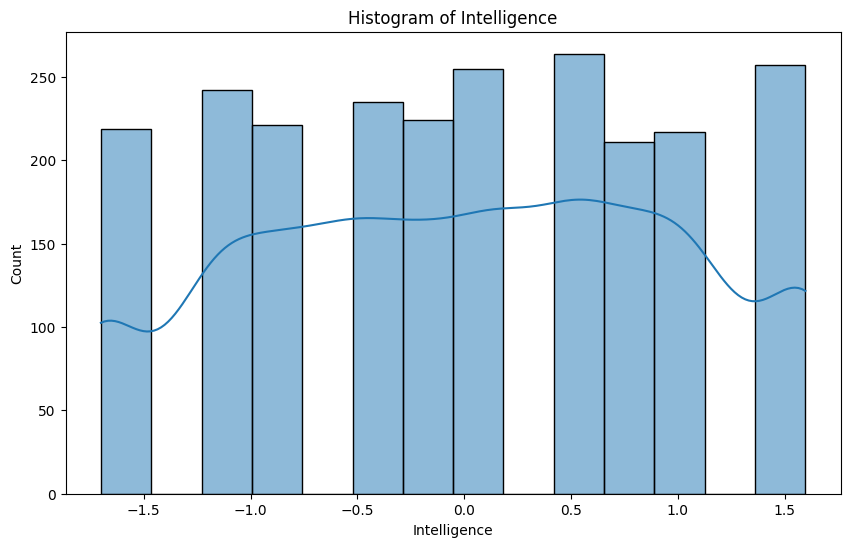

In [16]:
numerical_columns = ['Strength', 'Speed', 'Intelligence']
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f"Histogram of {column}")
    plt.show()

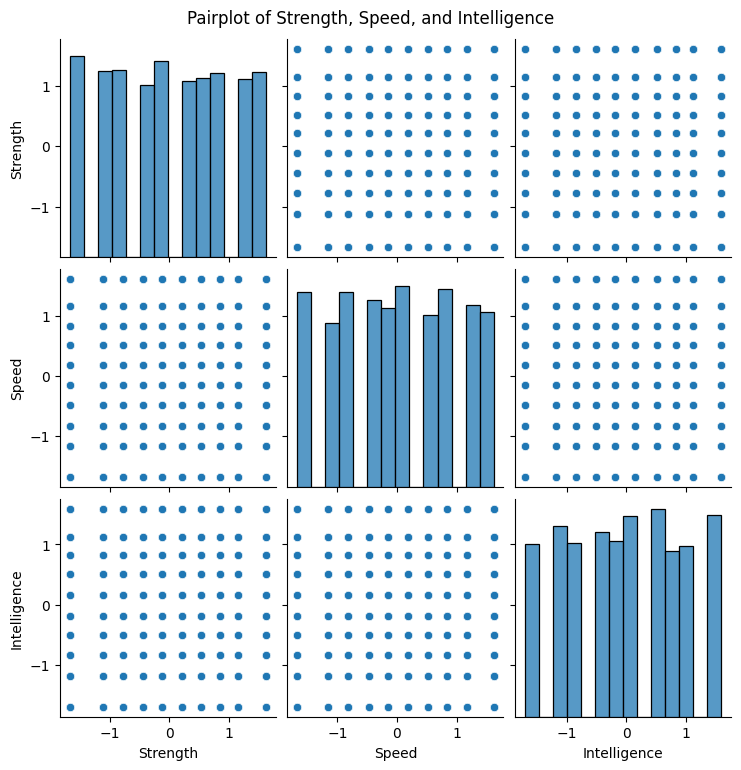

In [17]:
# Pairplot
sns.pairplot(df[['Strength', 'Speed', 'Intelligence']])
plt.suptitle("Pairplot of Strength, Speed, and Intelligence", y=1.02)
plt.show()

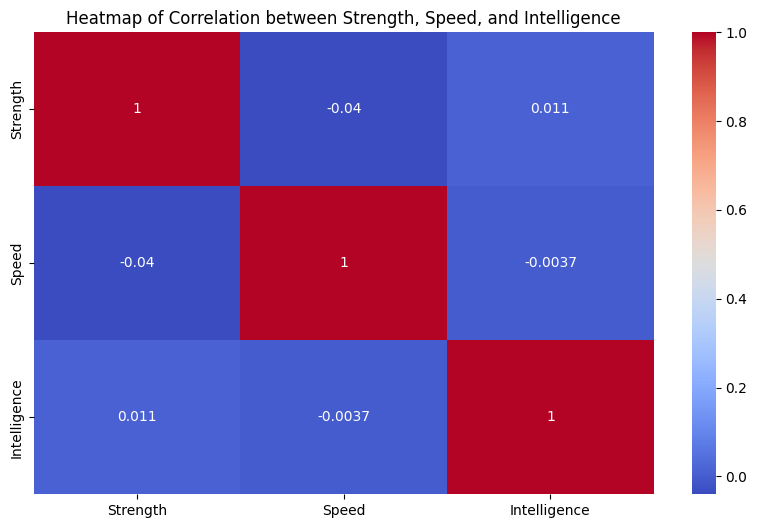

In [18]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Strength', 'Speed', 'Intelligence']].corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap of Correlation between Strength, Speed, and Intelligence")
plt.show()

In [19]:
# Encode categorical variables
le = LabelEncoder()
df['Character'] = le.fit_transform(df['Character'])
df['Universe'] = le.fit_transform(df['Universe'])
df['SpecialAbilities'] = le.fit_transform(df['SpecialAbilities'])
df['Weaknesses'] = le.fit_transform(df['Weaknesses'])

In [20]:
# Split data into train and test sets
X = df.drop('BattleOutcome', axis=1)
y = df['BattleOutcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Define classifier models
models = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

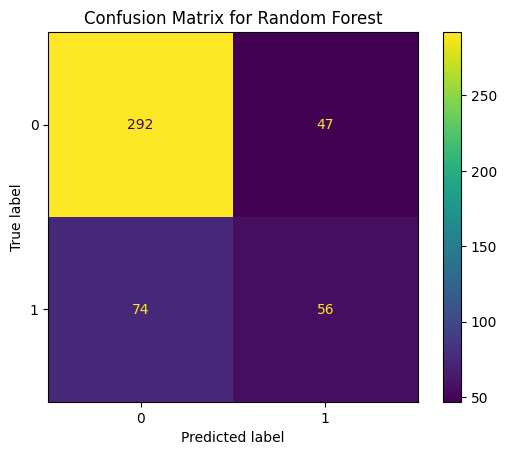

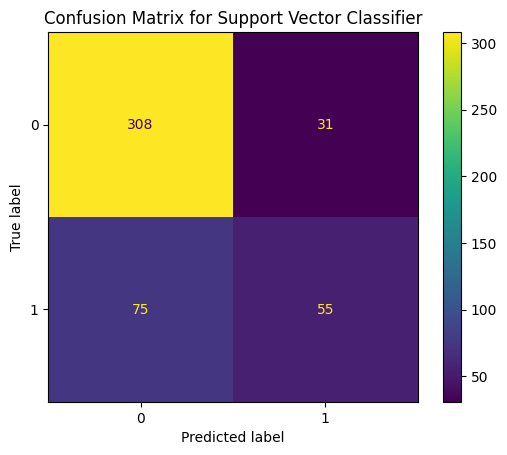

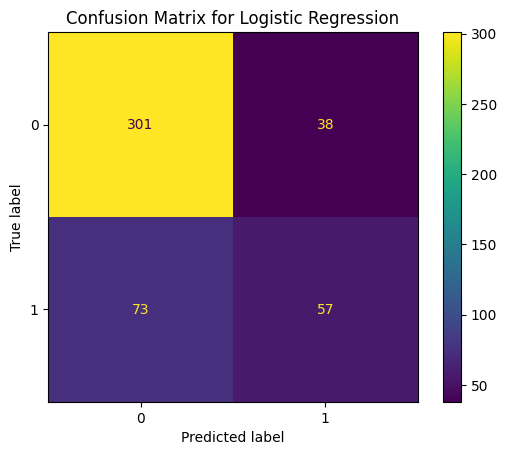

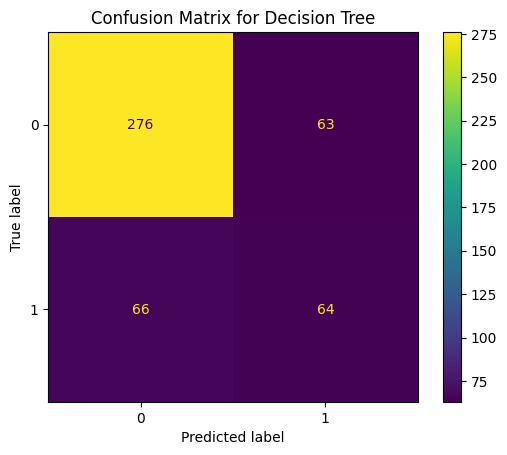

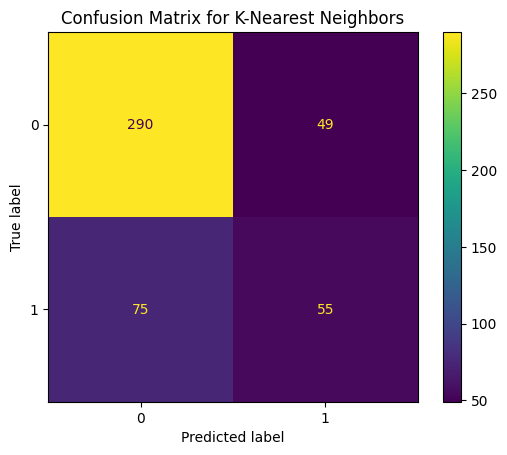

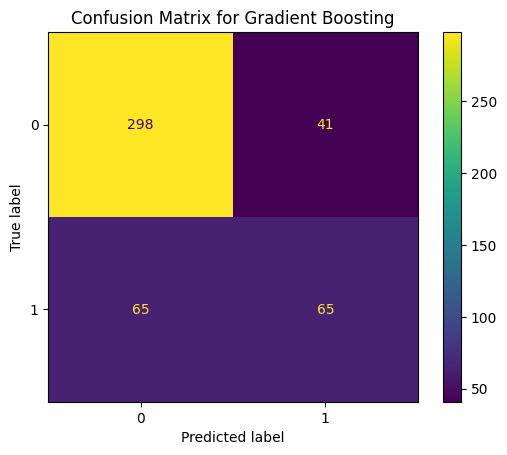

/opt/app-root/lib64/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


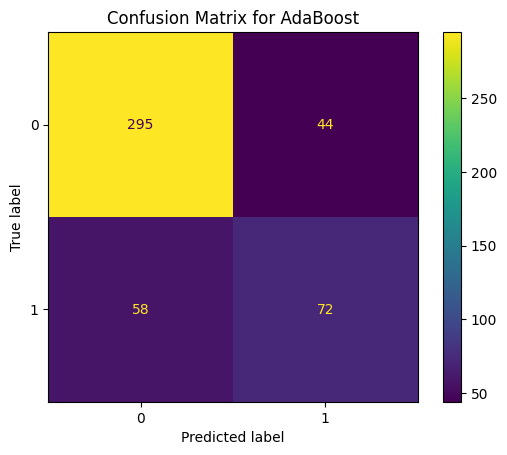

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.742004,0.670752,0.646063,0.654528
1,Support Vector Classifier,0.773987,0.721856,0.665816,0.681222
2,Logistic Regression,0.763326,0.702406,0.663184,0.675493
3,Decision Tree,0.724947,0.655477,0.653233,0.654314
4,K-Nearest Neighbors,0.735608,0.661683,0.639267,0.646975
5,Gradient Boosting,0.773987,0.717072,0.689528,0.699925
6,AdaBoost,0.782516,0.728192,0.712026,0.718984


In [22]:
# Initialize a DataFrame to store evaluation results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Train and evaluate models
evaluation_results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']
    
    # Append results to list
    evaluation_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })
    
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Create DataFrame from evaluation results
results = pd.DataFrame(evaluation_results)

# Display evaluation results in table form
results

In [23]:
import pickle

filename = "battle.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

In [24]:
! mkdir models && mv battle.pickle models

mkdir: cannot create directory ‘models’: File exists
